In [1]:
import pandas as pd
import numpy as np
import os
import xlrd
from functools import reduce
from itertools import groupby
from matplotlib import pyplot as plt
plt.show()
import seaborn as sns; sns.set()
import altair as alt
alt.data_transformers.disable_max_rows()
import warnings
warnings.filterwarnings('ignore')

To read in these massive excel files first want to extract names of sheets

In [2]:
file1 = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/TenantLeasePayments_Trending_(Active)_May_2020_Sept_2020.xlsx"
file2 = "/Users/quinnunderriner/Desktop/Work/eden_rent_roll/Tenant_Lease_Payments_May 2019_Sept_2019.xlsx"

In [3]:
xls = xlrd.open_workbook(file1, on_demand=True)
may2020_sept2020 = xls.sheet_names()
may2020_sept2020 = [x for x in may2020_sept2020 if not x.endswith('Summary')] #we want to drop summary tabs 

In [4]:
# need to drop data from earlier in months where we have double data 
may2020_sept2020 = [x for x in may2020_sept2020 if not "15" in x]
may2020_sept2020 = [x for x in may2020_sept2020 if not "10" in x]


In [5]:
xls2 = xlrd.open_workbook(file2, on_demand=True)
may19_sept19 = xls2.sheet_names()

In [6]:
def read_in(file,sheet):
    """
    inputs:
        file (str): filepath of excel file
        sheet (str): name of sheet in excel sheet
    returns:
        df (dataframe)
    Read in data from a given excel sheet, do some cleaning and then 
    make new column names that adds the date for financial transaction 
    and drops the rest of the data. 
    """
    df = pd.read_excel(file,sheet_name =sheet)
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    df = df[:-2]#drop bottom two rows, which contain summary info
    df = df.reset_index().drop(columns=["index"])
    df = df[['Tenant Lease Charge','Is Subsidized?', 'Fixed Income?', 'Tenant Rent Collected',
             'Percent Collected',"Period","Tenant"]]
    df = df.rename(columns={"Tenant Lease Charge":"Tenant Lease Charge"+" "+df["Period"][5],
                   "Tenant Rent Collected":"Tenant Rent Charge"+" "+df["Period"][5],
                  "Percent Collected":"Tenant Percent Collected"+" "+df["Period"][5],
                   'Is Subsidized?':"Is Subsidized?"+" "+df["Period"][5], 
                    'Fixed Income?':"Fixed Income?"+" "+df["Period"][5]}) 
    df = df.drop(columns={"Period"})
    return df

In [57]:
def read_in_check_status(file,sheet):
    """
    inputs:
        file (str): filepath of excel file
        sheet (str): name of sheet in excel sheet
    returns:
        df (dataframe)
    Read in data from a given excel sheet, do some cleaning 
    """
    df = pd.read_excel(file,sheet_name =sheet)
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    df = df[:-2]#drop bottom two rows, which contain summary info
    df = df.reset_index().drop(columns=["index"])
    df = df.rename(columns={"Tenant Lease Charge":"Tenant Lease Charge"+" "+df["Period"][5],
                   "Tenant Rent Collected":"Tenant Rent Charge"+" "+df["Period"][5],
                  "Percent Collected":"Tenant Percent Collected"+" "+df["Period"][5]})

    #df = df.drop(columns={"Period"})
    return df

In [8]:
def make_header(df):
    """
    inputs:
        df (dataframe)
    returns:
        df (dataframe)
    do some basic cleanup of the header row 
    """
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    return df

In [58]:
#read in the correct sheets from all files calling read_in function 
df = read_in_check_status(file2,may19_sept19[0])

df_list = [df, read_in(file2,may19_sept19[1]),
           read_in(file2,may19_sept19[2]),
           read_in(file2,may19_sept19[3]),
           read_in(file2,may19_sept19[4]),
           read_in(file1,may2020_sept2020[0]),
           read_in(file1,may2020_sept2020[1]),
           read_in(file1,may2020_sept2020[2]),
           read_in(file1,may2020_sept2020[3]),
           read_in(file1,may2020_sept2020[4])]

In [379]:
df_list[1]

4,Tenant Lease Charge 06/01/19 - 06/30/19,Is Subsidized? 06/01/19 - 06/30/19,Fixed Income? 06/01/19 - 06/30/19,Tenant Rent Charge 06/01/19 - 06/30/19,Tenant Percent Collected 06/01/19 - 06/30/19,Tenant
0,391,Yes,NaN,391,100,t0028148
1,229,Yes,NaN,239,104.37,t0009751
2,0,NaN,NaN,0,0,t0029469
3,510,Yes,NaN,510,100,t0023101
4,353,Yes,SS,353,100,t0000702
...,...,...,...,...,...,...
9499,374,Yes,SS,374,100,t0028619
9500,532,Yes,NaN,747,140.41,t0028620
9501,0,Yes,NaN,0,0,t0028622
9502,1347,NaN,NaN,1347,100,t0028624


In [59]:
#This lambda function then merges all the dataframes from df_list together 
df_final = reduce(lambda left,right: pd.merge(left,right,on='Tenant'), df_list)

df_final = df_final.drop(columns=["Name","Period"]) #drop cols

In [39]:
#write out initial data to csv
df_final.to_csv("Inital_eden_rent_roll_data_19-20_v2.csv")

Q: “Have rent collections changed in 2020 compared to last year (e.g., collective rent roll shortfalls, number of tenants with underpayment or no payment in each month)?”
 


Need to melt dataset so each row is amount of rent collected in a given month to be able to do groupbys

In [60]:
#grab initial fixed columns for first month in dataset 
fixed_cols = ['Property', 'Property Name', 'City', 'County', 'Unit', 'Tenant',
       'Is Subsidized?', 'Fixed Income?']

In [61]:
# additionally grab just monthly percentage payment columns 
percent_collected = [num for num in df_final.columns if ("Percent") in num]

In [62]:
#merge these two lists in the total list of columns we want so we can melt dataset 
# for this initial analysis assuming that fixed income status and stuff do not change
collect = fixed_cols + percent_collected
df_rent_collected = df_final[collect]

In [63]:
#create a melted dataset so that each row is a payment 
monthly_percent_collected = pd.melt(df_rent_collected, id_vars=fixed_cols,var_name='Percent Collected')

In [98]:
monthly_percent_collected

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Percent Collected,Percentage of Rent Paid,year,Assistance
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes,No Assistance,2019-05-31,98.98,19,Yes No Assistance
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes,No Assistance,2019-05-31,100.00,19,Yes No Assistance
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,NaN,No Assistance,2019-05-31,0.00,19,NaN
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes,No Assistance,2019-05-31,100.00,19,Yes No Assistance
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes,SS,2019-05-31,100.00,19,Yes SS
...,...,...,...,...,...,...,...,...,...,...,...,...
90635,998,Tennyson Garden Apartments,Hayward,Alameda,983-303,t0028619,Yes,SS,2020-09-30,104.52,20,Yes SS
90636,998,Tennyson Garden Apartments,Hayward,Alameda,983-304,t0028620,Yes,No Assistance,2020-09-30,52.50,20,Yes No Assistance
90637,998,Tennyson Garden Apartments,Hayward,Alameda,983-305,t0028622,Yes,No Assistance,2020-09-30,100.00,20,Yes No Assistance
90638,998,Tennyson Garden Apartments,Hayward,Alameda,983-306,t0028624,NaN,No Assistance,2020-09-30,100.00,20,NaN


In [65]:
# there are 90,640 payments in this dataset 
len(monthly_percent_collected)

90640

In [66]:
# to group by year, need a year col 
monthly_percent_collected["year"] = monthly_percent_collected["Percent Collected"].str[-2:]

In [67]:
monthly_percent_collected["Percent Collected"].value_counts()

Tenant Percent Collected 09/01/20 - 09/30/20    9064
Tenant Percent Collected 09/01/19 - 09/30/19    9064
Tenant Percent Collected 05/01/19 - 05/31/19    9064
Tenant Percent Collected 08/01/20 - 08/31/20    9064
Tenant Percent Collected 06/01/19 - 06/30/19    9064
Tenant Percent Collected 05/01/20 - 05/31/20    9064
Tenant Percent Collected 06/01/20 - 06/30/20    9064
Tenant Percent Collected 07/01/20 - 07/31/20    9064
Tenant Percent Collected 08/01/19 - 08/31/19    9064
Tenant Percent Collected 07/01/19 - 07/31/19    9064
Name: Percent Collected, dtype: int64

In [19]:
len(monthly_percent_collected[monthly_percent_collected.value > 100])

14577

In [69]:
#16 percent of all payments exceed total, implying paying back rent. 
len(monthly_percent_collected[monthly_percent_collected.value > 100])/ len(monthly_percent_collected)

0.16082303618711385

In [21]:
#negative rent total 
len(monthly_percent_collected[monthly_percent_collected.value < 0])

63

In [22]:
(len(monthly_percent_collected[monthly_percent_collected.value < 0])/len(monthly_percent_collected))

0.0006950573698146514

In [70]:
#I'm going to drop these negative values as I believe them to be errors. 
monthly_percent_collected = monthly_percent_collected[monthly_percent_collected.value >= 0]

In [71]:
monthly_percent_collected.value = monthly_percent_collected.value.astype(float) #make value type that works with groupby 
monthly_percent_collected[monthly_percent_collected.value <=100][["year","value"]].groupby("year").describe().round(2)

value                                                
        count   mean    std  min     25%    50%    75%    max
year                                                         
19    37847.0  78.49  40.65  0.0   98.74  100.0  100.0  100.0
20    38153.0  91.36  26.73  0.0  100.00  100.0  100.0  100.0

In [72]:
#count the number of non payments per year 
monthly_percent_collected[["year","value"]].groupby('year').agg(lambda x: x.eq(0).sum())

,value
year,
19,7898.0
20,2727.0


In [26]:
7898.0 + 2727.0

10625.0

Q: “For tenants who are short or don't pay rent...is that typically a one-off thing or are they likely to be in arrears multiple months. How far short do they tend to be? Has that shifted in 2020?”

In [73]:
#create a datetime column to make altair happy 
monthly_percent_collected_chart = monthly_percent_collected
monthly_percent_collected_chart["Percent Collected"] = monthly_percent_collected_chart["Percent Collected"].str[-8:]
monthly_percent_collected_chart["Percent Collected"] = pd.to_datetime(monthly_percent_collected_chart["Percent Collected"])

In [74]:
monthly_percent_collected_chart = monthly_percent_collected_chart[["value","Percent Collected"]].groupby("Percent Collected").mean().reset_index()

NOTE I DROPPED THE CONFIDENCE BANDS FROM THIS CHART TO MAKE THE NOTEBOOK FILE SMALL ENOUGH TO LOAD ONTO GITHUB
CAN BRING THEM BACK EASILY IF NEEDED 

In [ ]:
line = line_chart = alt.Chart(monthly_percent_collected_chart).mark_line(color="#FFAA00").encode(
        alt.X('Percent Collected',
        scale=alt.Scale(zero=False)
    ),


    alt.Y("value", scale=alt.Scale(zero=False))
)

band = line_chart = alt.Chart(monthly_percent_collected_chart).mark_errorband(extent='ci').encode(
        alt.X('Percent Collected',
        scale=alt.Scale(zero=False)
    ),


    alt.Y("value", scale=alt.Scale(zero=False))
)

band + line

In [75]:
#melt, group by person, do a value counts 
people_with_nonpayment = df_rent_collected.loc[~(df_rent_collected != 0).all(axis=1), :]
len(people_with_nonpayment)

2647

There are 2647 people who have at least one nonpayment.


In [208]:
people_with_nonpayment_data_only = people_with_nonpayment_data_only.drop(columns="conseq_0")
people_with_nonpayment_data_only = people_with_nonpayment[percent_collected]

In [296]:
def count0(a):
    b = [sum(1 for i in g) for k,g in groupby(a) if k==0]
    if len(b)>0:
        return b
    else:
        return [0]
people_with_nonpayment_data_only['zeros2'] = people_with_nonpayment_data_only.apply(lambda x: count0(x.values), axis=1)

In [295]:
people_with_nonpayment_data_only = people_with_nonpayment[percent_collected]

In [314]:
people_with_nonpayment_data_only

4,Tenant Percent Collected 05/01/19 - 05/31/19,Tenant Percent Collected 06/01/19 - 06/30/19,Tenant Percent Collected 07/01/19 - 07/31/19,Tenant Percent Collected 08/01/19 - 08/31/19,Tenant Percent Collected 09/01/19 - 09/30/19,Tenant Percent Collected 05/01/20 - 05/31/20,Tenant Percent Collected 06/01/20 - 06/30/20,Tenant Percent Collected 07/01/20 - 07/31/20,Tenant Percent Collected 08/01/20 - 08/31/20,Tenant Percent Collected 09/01/20 - 09/30/20,zeros2
2,0,0,0,0,0,100,100,100,100,100,[5]
5,0,0,0,0,0,0,0,0,0,0,[10]
7,0,0,0,0,0,100,100,100,100,100,[5]
44,0,0,0,0,0,100,100,100,100,100,[5]
46,0,0,307.89,100,100,100,100,100,100,100,[2]
...,...,...,...,...,...,...,...,...,...,...,...
9057,109.21,100.76,100.68,100.68,100.68,100,100,0,94.64,100,[1]
9058,0,0,0,0,0,0,0,0,0,0,[10]
9060,140.04,140.41,139.66,139.66,116.46,0,100,200,100,52.5,[1]
9061,0,0,0,0,100,100.5,100.5,100.5,100.5,100,[4]


In [315]:
nonpayment_stretches = []
for i in people_with_nonpayment_data_only.zeros2:
    nonpayment_stretches += i


In [327]:
sum(nonpayment_stretches)/len(nonpayment_stretches)

3.3037935323383083

now we want to see if this calculation differs by year

In [332]:
people_with_nonpayment_19

4,Tenant Percent Collected 05/01/19 - 05/31/19,Tenant Percent Collected 06/01/19 - 06/30/19,Tenant Percent Collected 07/01/19 - 07/31/19,Tenant Percent Collected 08/01/19 - 08/31/19,Tenant Percent Collected 09/01/19 - 09/30/19,zeros2
2,0,0,0,0,0,[5]
5,0,0,0,0,0,[5]
7,0,0,0,0,0,[5]
44,0,0,0,0,0,[5]
46,0,0,307.89,100,100,[2]
...,...,...,...,...,...,...
9057,109.21,100.76,100.68,100.68,100.68,[0]
9058,0,0,0,0,0,[5]
9060,140.04,140.41,139.66,139.66,116.46,[0]
9061,0,0,0,0,100,[4]


In [333]:
people_with_nonpayment_20

4,Tenant Percent Collected 05/01/20 - 05/31/20,Tenant Percent Collected 06/01/20 - 06/30/20,Tenant Percent Collected 07/01/20 - 07/31/20,Tenant Percent Collected 08/01/20 - 08/31/20,Tenant Percent Collected 09/01/20 - 09/30/20,zeros2
2,100,100,100,100,100,[0]
5,0,0,0,0,0,[5]
7,100,100,100,100,100,[0]
44,100,100,100,100,100,[0]
46,100,100,100,100,100,[0]
...,...,...,...,...,...,...
9057,100,100,0,94.64,100,[1]
9058,0,0,0,0,0,[5]
9060,0,100,200,100,52.5,[1]
9061,100.5,100.5,100.5,100.5,100,[0]


In [334]:
people_with_nonpayment_19 = people_with_nonpayment[[x for x in people_with_nonpayment if  x.endswith('19')]]
people_with_nonpayment_20 = people_with_nonpayment[[x for x in people_with_nonpayment if  x.endswith('20')]]

In [335]:
people_with_nonpayment_19['zeros2'] = people_with_nonpayment_19.apply(lambda x: count0(x.values), axis=1)
people_with_nonpayment_20['zeros2'] = people_with_nonpayment_20.apply(lambda x: count0(x.values), axis=1)


In [336]:
people_with_nonpayment_20.head()

4,Tenant Percent Collected 05/01/20 - 05/31/20,Tenant Percent Collected 06/01/20 - 06/30/20,Tenant Percent Collected 07/01/20 - 07/31/20,Tenant Percent Collected 08/01/20 - 08/31/20,Tenant Percent Collected 09/01/20 - 09/30/20,zeros2
2,100,100,100,100,100,[0]
5,0,0,0,0,0,[5]
7,100,100,100,100,100,[0]
44,100,100,100,100,100,[0]
46,100,100,100,100,100,[0]


In [255]:
def count_nonpayment(df):
    nonpayment_stretches = []
    for i in people_with_nonpayment_data_only.zeros2:
        nonpayment_stretches += i
    return sum(nonpayment_stretches)/len(nonpayment_stretches)

In [337]:
nonpayment_stretches_19 = []
for i in people_with_nonpayment_19.zeros2:
    nonpayment_stretches_19 += i
sum(nonpayment_stretches_19)/len(nonpayment_stretches_19)

2.91546696197859

(array([ 677.,    0.,  437.,    0.,   99.,    0.,   82.,    0.,   53.,
        1361.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

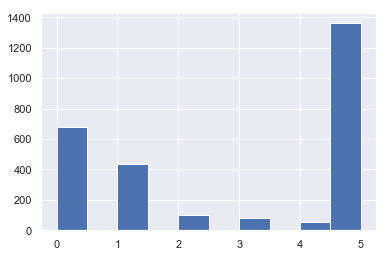

In [340]:
plt.hist(nonpayment_stretches_19)

In [338]:
nonpayment_stretches_20 = []
for i in people_with_nonpayment_20.zeros2:
    nonpayment_stretches_20 += i
sum(nonpayment_stretches_20)/len(nonpayment_stretches_20)

0.9442520775623269

(array([1421.,    0.,  981.,    0.,  167.,    0.,   79.,    0.,   25.,
         215.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

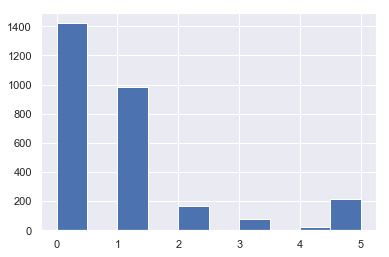

In [341]:
plt.hist(nonpayment_stretches_20)

In [77]:
nonpayment_only = people_with_nonpayment[['Tenant Percent Collected 05/01/19 - 05/31/19',
       'Tenant Percent Collected 06/01/19 - 06/30/19',
       'Tenant Percent Collected 07/01/19 - 07/31/19',
       'Tenant Percent Collected 08/01/19 - 08/31/19',
       'Tenant Percent Collected 09/01/19 - 09/30/19',
       'Tenant Percent Collected 05/01/20 - 05/31/20',
       'Tenant Percent Collected 06/01/20 - 06/30/20',
       'Tenant Percent Collected 07/01/20 - 07/31/20',
       'Tenant Percent Collected 08/01/20 - 08/31/20',
       'Tenant Percent Collected 09/01/20 - 09/30/20']]

In [78]:
melted_nonpayment = pd.melt(people_with_nonpayment, id_vars=fixed_cols,var_name='Percent Collected')

In [79]:
melted_nonpayment = melted_nonpayment[['Tenant', 'value']]
melted_nonpayment.value = melted_nonpayment.value.astype(float)

now calculate the total number of nonpayments in the dataset

In [81]:
melted_nonpayment

,Tenant,value
0,t0029469,0.0
1,t0000690,0.0
2,t0098684,0.0
3,t0852179,0.0
4,t0029300,0.0
...,...,...
26465,t0028617,100.0
26466,t0028632,0.0
26467,t0028620,52.5
26468,t0028622,100.0


10625 Total nonpayments in the dataset. 

In [83]:
(melted_nonpayment.value == 0).sum()

10625

In [85]:
melted_nonpayment_des = melted_nonpayment.groupby("Tenant").describe().reset_index()

In [88]:
monthly_percent_collected["Fixed Income?"] = monthly_percent_collected["Fixed Income?"].replace(np.nan, 'No Assistance', regex=True)
monthly_percent_collected[["Fixed Income?","value"]].groupby("Fixed Income?").mean().round(2)

,value
Fixed Income?,
No Assistance,89.59
SS,99.16
SS/SSI,100.77
SSI,100.32


In [87]:
monthly_percent_collected.head()

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Percent Collected,value,year
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes,No Assistance,2019-05-31,98.98,19
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes,No Assistance,2019-05-31,100.00,19
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,NaN,No Assistance,2019-05-31,0.00,19
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes,No Assistance,2019-05-31,100.00,19
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes,SS,2019-05-31,100.00,19


In [89]:
df_rent_collected["Fixed Income?"] = df_rent_collected["Fixed Income?"].replace(np.nan, 'No Assistance', regex=True)
df_rent_collected["Is Subsidized?"] = df_rent_collected["Is Subsidized?"].replace(np.nan, 'No', regex=True)
df_rent_collected["Is Subsidized?"] = df_rent_collected["Is Subsidized?"] + " " + "Subsidy"
df_rent_collected["Assistance"] = df_rent_collected["Is Subsidized?"] +" "+ df_rent_collected["Fixed Income?"]

In [90]:
df_rent_collected["Fixed Income?"].value_counts()

No Assistance    6239
SS               1413
SSI               768
SS/SSI            644
Name: Fixed Income?, dtype: int64

In [91]:
df_rent_collected["Is Subsidized?"].value_counts()

No Subsidy     5617
Yes Subsidy    3447
Name: Is Subsidized?, dtype: int64

In [92]:
4507 /(5617 + 3447)

0.49724183583406883

0.49 percent of people have no form of gov assistance 

In [93]:
df_rent_collected["Assistance"].value_counts()

No Subsidy No Assistance     4507
Yes Subsidy No Assistance    1732
Yes Subsidy SS                768
No Subsidy SS                 645
Yes Subsidy SSI               485
Yes Subsidy SS/SSI            462
No Subsidy SSI                283
No Subsidy SS/SSI             182
Name: Assistance, dtype: int64

In [94]:
monthly_percent_collected["Assistance"] = monthly_percent_collected["Is Subsidized?"] +" "+ monthly_percent_collected["Fixed Income?"]

In [100]:
monthly_percent_collected = monthly_percent_collected.rename(columns={"value":"Percentage of Rent Paid"})

In [102]:
monthly_percent_collected[["Fixed Income?","Percentage of Rent Paid","year"]].groupby(["Fixed Income?","year"]).mean().round(2)

Percentage of Rent Paid
Fixed Income? year                         
No Assistance 19                      82.99
              20                      96.19
SS            19                      98.36
              20                      99.96
SS/SSI        19                     101.35
              20                     100.18
SSI           19                     101.08
              20                      99.55

In [103]:
monthly_percent_collected[["Is Subsidized?","Percentage of Rent Paid","year"]].groupby(["Is Subsidized?","year"]).mean()

Percentage of Rent Paid
Is Subsidized? year                         
Yes            19                 105.675739
               20                  99.720503

In [104]:
monthly_percent_collected["Fixed Income?"] = monthly_percent_collected["Fixed Income?"].replace(np.nan, 'No Assistance', regex=True)
monthly_percent_collected["Is Subsidized?"] = monthly_percent_collected["Is Subsidized?"].replace(np.nan, 'No', regex=True)
monthly_percent_collected["Is Subsidized?"] = monthly_percent_collected["Is Subsidized?"] + " " + "Subsidy"
monthly_percent_collected["Assistance"] = monthly_percent_collected["Is Subsidized?"] +" "+ monthly_percent_collected["Fixed Income?"]

In [105]:
monthly_percent_collected["Assistance"].value_counts()

No Subsidy No Assistance     45062
Yes Subsidy No Assistance    17271
Yes Subsidy SS                7677
No Subsidy SS                 6449
Yes Subsidy SSI               4848
Yes Subsidy SS/SSI            4620
No Subsidy SSI                2830
No Subsidy SS/SSI             1820
Name: Assistance, dtype: int64

In [106]:
def any_aid(x):
    if x == "No Subsidy No Assistance":
        return "No Aid"
    else:
        return "Aid"

In [107]:
monthly_percent_collected["Aid"] = monthly_percent_collected.Assistance.apply(lambda x: any_aid(x))

In [109]:
monthly_percent_collected = monthly_percent_collected.rename(columns={"value":"Percentage of Rent Paid"})

In [110]:
monthly_percent_collected[["Aid","Percentage of Rent Paid","year"]].groupby(["Aid","year"]).mean()

Percentage of Rent Paid
Aid    year                         
Aid    19                 102.643698
       20                  99.771580
No Aid 19                  73.657068
       20                  94.904618

In [111]:
monthly_percent_collected["Percentage of Rent Paid"].value_counts()

100.00    59528
0.00      10625
200.00      396
100.23      138
100.41      118
          ...  
126.74        1
31.69         1
81.94         1
173.54        1
115.73        1
Name: Percentage of Rent Paid, Length: 5777, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f53fb00>]],
      dtype=object)

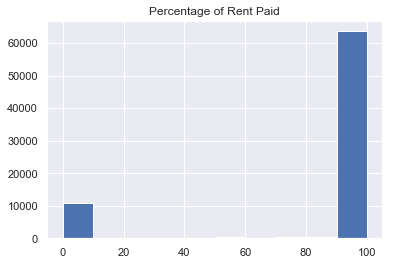

In [112]:
monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<=100].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fad9898>]],
      dtype=object)

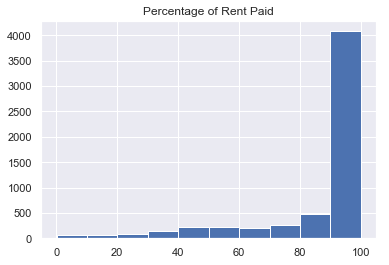

In [113]:
extra_hist = monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<100]
extra_hist = extra_hist[extra_hist["Percentage of Rent Paid"]>0]
extra_hist.hist()

In [114]:
monthly_percent_collected.head()

,Property,Property Name,City,County,Unit,Tenant,Is Subsidized?,Fixed Income?,Percent Collected,Percentage of Rent Paid,year,Assistance,Aid
0,304,Almond Terrace,Manteca,San Joaquin,A101,t0028148,Yes Subsidy,No Assistance,2019-05-31,98.98,19,Yes Subsidy No Assistance,Aid
1,304,Almond Terrace,Manteca,San Joaquin,A102,t0009751,Yes Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy No Assistance,Aid
2,304,Almond Terrace,Manteca,San Joaquin,A103,t0029469,No Subsidy,No Assistance,2019-05-31,0.00,19,No Subsidy No Assistance,No Aid
3,304,Almond Terrace,Manteca,San Joaquin,A104,t0023101,Yes Subsidy,No Assistance,2019-05-31,100.00,19,Yes Subsidy No Assistance,Aid
4,304,Almond Terrace,Manteca,San Joaquin,A105,t0000702,Yes Subsidy,SS,2019-05-31,100.00,19,Yes Subsidy SS,Aid


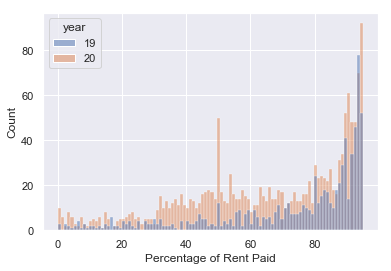

In [115]:
group_hist = monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<95]
group_hist = group_hist[group_hist["Percentage of Rent Paid"]>0]
sns.histplot(data=group_hist, x="Percentage of Rent Paid", hue="year", bins=100
            )

Q: “Are rent shortfalls concentrated in certain properties or regions of the state?”


In [117]:
monthly_percent_collected = monthly_percent_collected[monthly_percent_collected["Percentage of Rent Paid"]<=100]

In [118]:
by_county = monthly_percent_collected[["County","Percentage of Rent Paid"]].groupby("County").describe().reset_index()

In [119]:
by_county.sort_values([('Percentage of Rent Paid', 'mean')], ascending=False).round(2)

County Percentage of Rent Paid                                    \
                                   count   mean    std  min     25%    50%   
7      San Diego                  5002.0  95.61  19.26  0.0  100.00  100.0   
6     San Benito                   955.0  94.52  20.74  0.0  100.00  100.0   
11    Santa Cruz                  2219.0  94.03  23.04  0.0  100.00  100.0   
5         Orange                  1284.0  92.94  23.84  0.0  100.00  100.0   
4       Monterey                  3409.0  91.70  26.47  0.0  100.00  100.0   
10   Santa Clara                 13595.0  90.98  27.81  0.0  100.00  100.0   
0        Alameda                 23202.0  87.45  32.16  0.0  100.00  100.0   
3          Marin                   957.0  86.88  32.94  0.0  100.00  100.0   
2    Los Angeles                   320.0  85.81  33.49  0.0  100.00  100.0   
1   Contra Costa                  8102.0  85.71  33.98  0.0  100.00  100.0   
8    San Joaquin                  2832.0  82.58  37.75  0.0  100.00  100.0   
14          Yolo                  1340.0  77.93  40.11  0.0   94.88  100.0   
9      San Mateo                   123.0  77.19  42.08  0.0   99.08  100.0   
13        Sonoma                  5295.0  75.59  42.58  0.0   83.31  100.0   
12        Solano                  7365.0  58.14  48.84  0.0    0.00  100.0   

                  
      75%    max  
7   100.0  100.0  
6   100.0  100.0  
11  100.0  100.0  
5   100.0  100.0  
4   100.0  100.0  
10  100.0  100.0  
0   100.0  100.0  
3   100.0  100.0  
2   100.0  100.0  
1   100.0  100.0  
8   100.0  100.0  
14  100.0  100.0  
9   100.0  100.0  
13  100.0  100.0  
12  100.0  100.0

In [120]:
#calculate number of nonpayments by 
no_payments_county = people_with_nonpayment.groupby("County").count().reset_index()[["County","Property"]]
total_counts = df_rent_collected.groupby("County").count().reset_index()[["County","Property"]]
no_payments_county = no_payments_county.merge(total_counts,on="County")
no_payments_county["No Payment as a Percent of Total Payments"] = no_payments_county.Property_x/no_payments_county.Property_y

In [121]:
no_payments_county = no_payments_county[["County","No Payment as a Percent of Total Payments"]]
no_payments_county.sort_values("No Payment as a Percent of Total Payments",ascending=False).reset_index().drop(columns={"index"}).round(3)

4,County,No Payment as a Percent of Total Payments
0,Solano,0.739
1,Sonoma,0.411
2,Yolo,0.373
3,Contra Costa,0.323
4,San Joaquin,0.322
5,Marin,0.318
6,Los Angeles,0.310
7,Alameda,0.255
8,San Mateo,0.219
9,Monterey,0.216


“Are rent shortfalls concentrated in certain properties?"

In [123]:
monthly_percent_collected =monthly_percent_collected.rename(columns={"Percent Collected":"Date Collected"})

In [129]:
by_property = monthly_percent_collected[["Property Name","Percentage of Rent Paid"]].groupby("Property Name").describe().reset_index().round(2)
by_property.sort_values([('Percentage of Rent Paid', 'mean')], ascending=False).round(2)

Property Name Percentage of Rent Paid         \
                                                               count   mean   
134                         Westside Terrace                   133.0  98.44   
86   Pauline Weaver Senior Apartments (Four)                   421.0  97.69   
102                        Skeels Apartments                   114.0  97.58   
12                  Brentwood Senior Commons                   700.0  97.36   
115                             Tierra Linda                   142.0  96.77   
..                                       ...                     ...    ...   
68                 Lincoln Corner Apartments                  1240.0  43.66   
118                  Vacaville Meadows Drive                   550.0  42.67   
58                      Highlands Apartments                    81.0  42.32   
138                       Willows Apartments                  1060.0  41.24   
89                      Quail Run Apartments                  1658.0  39.11   

                                               
       std    min    25%    50%    75%    max  
134   7.33  34.31  100.0  100.0  100.0  100.0  
86   13.85   0.00  100.0  100.0  100.0  100.0  
102  12.06   0.00  100.0  100.0  100.0  100.0  
12   15.67   0.00  100.0  100.0  100.0  100.0  
115  17.18   0.00  100.0  100.0  100.0  100.0  
..     ...    ...    ...    ...    ...    ...  
68   49.24   0.00    0.0    0.0  100.0  100.0  
118  49.20   0.00    0.0    0.0  100.0  100.0  
58   49.41   0.00    0.0    0.0  100.0  100.0  
138  48.94   0.00    0.0    0.0  100.0  100.0  
89   48.50   0.00    0.0    0.0  100.0  100.0  

[142 rows x 9 columns]

In [130]:
#get ride of multi index
by_property.columns = by_property.columns.map(' '.join)


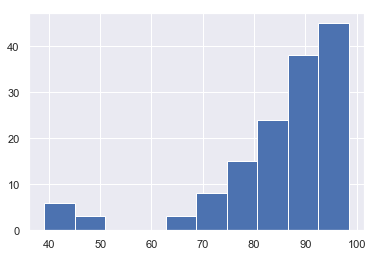

In [135]:
by_property["Percentage of Rent Paid mean"].hist()

In [139]:
monthly_percent_collected["CTYNAME"] = monthly_percent_collected["County"] + " County"

In [137]:
#need to map on FIPS code to be able to map data 
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
df_sample_r = df_sample[df_sample['STNAME'] == 'California']

In [141]:
df_sample_r = df_sample_r[["FIPS","CTYNAME"]]

In [186]:
county_map = monthly_percent_collected.merge(df_sample_r,on="CTYNAME",how="right")

In [187]:
county_map = county_map[["FIPS","Percentage of Rent Paid"]].rename(columns={"FIPS":"id","Percentage of Rent Paid":"rate"})

In [188]:
county_map['rate'] = county_map['rate'].fillna(0.1)

In [189]:
county_map['rate'] = np.log2(county_map['rate'])

In [190]:
county_map.to_csv("counties_map.csv")

In [158]:
from vega_datasets import data

counties = alt.topo_feature(data.us_10m.url, 'counties')
source = data.unemployment.url

In [178]:
source = "https://raw.githubusercontent.com/qunderriner/eden_rent_roll/main/counties_map.csv"

In [ ]:
data['logarithm_base2'] = np.log2(data['Salary'])

In [192]:
alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['rate'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

alt.Chart(...)

Does subsidy status change over time?

In [368]:
subsidized_filter = [x for x in df_final.columns if x.startswith('Is')]
fixed_filer = [x for x in df_final.columns if x.startswith('Fixed Income?')]

In [353]:
sub_status = df_final[subsidized_filter]

In [369]:
fixed_status = df_final[fixed_filer]

In [372]:
fixed_status["Fixed Income? 06/01/19 - 06/30/19"].value_counts()

SS        1466
SSI        808
SS/SSI     670
Name: Fixed Income? 06/01/19 - 06/30/19, dtype: int64

In [374]:
fixed_status = fixed_status.replace({"SS": "Yes", "SSI": "Yes","SS/SSI":"Yes"})

In [365]:
(sub_status.dropna(axis=0, how='all').shape[0] - sub_status.dropna(axis=0, how='any').shape[0])/sub_status.shape[0]

0.06310679611650485

In [375]:
(fixed_status.dropna(axis=0, how='all').shape[0] - fixed_status.dropna(axis=0, how='any').shape[0])/fixed_status.shape[0]

0.12411738746690203

6.3 percent of people have a change of housing subsidy status at some point in the dataset. 12.4 percent of people have a change of SS/SSI status. 

Q: “(was there more of a drop off [in number of tenants who have moved out]) this year compared to last? Were those dropoffs more concentrated in a certain month?)”

In [ ]:
#rerun this function without dropping the period column. I ran this all in a seperate notebook, but wanted
#the code in the same place 
def read_in2(file,sheet):
    """
    inputs:
        file (str): filepath of excel file
        sheet (str): name of sheet in excel sheet
    returns:
        df (dataframe)
    Read in data from a given excel sheet, do some cleaning and then 
    make new column names that adds the date for financial transaction 
    and drops the rest of the data. 
    """
    df = pd.read_excel(file,sheet_name =sheet)
    new_header = df.iloc[4] #grab the forth row for the header
    df = df[5:] #take the data less the blank rows
    df.columns = new_header
    df = df[:-2]#drop bottom two rows, which contain summary info
    df = df.reset_index().drop(columns=["index"])
    df = df[['Tenant Lease Charge','Is Subsidized?', 'Fixed Income?', 'Tenant Rent Collected',
             'Percent Collected',"Period","Tenant"]]
    df = df.rename(columns={"Tenant Lease Charge":"Tenant Lease Charge"+" "+df["Period"][5],
                   "Tenant Rent Collected":"Tenant Rent Charge"+" "+df["Period"][5],
                  "Percent Collected":"Tenant Percent Collected"+" "+df["Period"][5],
                   'Is Subsidized?':"Is Subsidized?"+" "+df["Period"][5], 
                    'Fixed Income?':"Fixed Income?"+" "+df["Period"][5]}) 
    #df = df.drop(columns={"Period"})
    return df

In [ ]:
df = read_in_check_status(file2,may19_sept19[0])

df_list = [df, read_in2(file2,may19_sept19[1]),
           read_in2(file2,may19_sept19[2]),
           read_in2(file2,may19_sept19[3]),
           read_in2(file2,may19_sept19[4]),
           read_in2(file1,may2020_sept2020[0]),
           read_in2(file1,may2020_sept2020[1]),
           read_in2(file1,may2020_sept2020[2]),
           read_in2(file1,may2020_sept2020[3]),
           read_in2(file1,may2020_sept2020[4])]

In [ ]:
#get total number of people in units 
for i in range(len(df_list)):
    date = df_list[i]["Period"][0][-8:]
    
    print(date,len(df_list[i])

In [ ]:
#set difference figures 
last_period = set(df_list[0]["Tenant"].unique())
for i in range(len(df_list)):
    date = df_list[i]["Period"][0][-8:]
    if i !=0:
        last_period = set(df_list[i-1]["Tenant"].unique())
        this_period = set(df_list[i]["Tenant"].unique())
        print(date,len(last_period.difference(this_period)))